# Assessment 1 

The goal of this assessment is to create a model submission to predict normal vs non-normal traffic under a given performance metric. The analysis will take place on the [KD99 (small, 10%) data set](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

To begin the assessment, we first need to import the data into our notebook.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import requests
import sklearn.metrics as metrics

%matplotlib inline
mpl.style.use('ggplot')

## Importing the Training/Test Data Set

The first data sets we import are the training/test data that split the data into a random 90% training data set and 10% testing data set with all the different types of attacks included in both sets.

In [2]:
#df_train = pd.read_csv('kd_train.csv')
#df_test = pd.read_csv('kd_test.csv')

df_train = pd.read_csv("https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/kd_train.csv.zip")
df_test = pd.read_csv("https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/kd_test.csv.zip")

In [3]:
print(df_test.shape)
df_test.head()

(49402, 43)


,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,392651,0,tcp,private,S0,0,0,0,0,0,...,1,0.00,0.05,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
1,416720,0,icmp,ecr_i,SF,520,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
2,483162,0,tcp,http,SF,186,21709,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.
3,357133,0,tcp,private,S0,0,0,0,0,0,...,18,0.07,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
4,30264,0,tcp,http,SF,341,6843,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
print(df_train.shape)
df_train.head()

(444619, 44)


,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,folds
0,44625,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
1,339463,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
2,321570,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
3,355860,0,tcp,private,S0,0,0,0,0,0,...,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.,1
4,9708,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1


## Importing the other Data Sets

One of the things I want to do within this model testing is to see how well we can predict out of sample data. Therefore, I will use the other data sets I have created to analyse how well the model predicts a new attack it has no specific knowledge of.

In [5]:
#df_teardrop = pd.read_csv('KD99_teardrop.csv') # testing data
#df_noteardrop = pd.read_csv('KD99_noteardrop.csv') # training data

df_teardrop = pd.read_csv('https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/KD99_teardrop.csv.zip') # testing data
df_noteardrop = pd.read_csv('https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/KD99_noteardrop.csv.zip') # training data

In [6]:
print(df_teardrop.shape)
df_teardrop.head()

(979, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,udp,private,SF,28,0,0,1,0,0,...,1,0.01,0.05,0.01,0.0,0.0,0.0,0.0,0.0,teardrop.
1,0,udp,private,SF,28,0,0,3,0,0,...,2,0.03,0.05,0.03,0.0,0.0,0.0,0.0,0.0,teardrop.
2,0,udp,private,SF,28,0,0,3,0,0,...,3,0.04,0.05,0.04,0.0,0.0,0.0,0.0,0.0,teardrop.
3,0,udp,private,SF,28,0,0,3,0,0,...,4,0.05,0.05,0.05,0.0,0.0,0.0,0.0,0.0,teardrop.
4,0,udp,private,SF,28,0,0,3,0,0,...,5,0.06,0.05,0.06,0.0,0.0,0.0,0.0,0.0,teardrop.


In [7]:
print(df_noteardrop.shape)
df_noteardrop.head()

(493042, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [8]:
#df_rootkit = pd.read_csv('KD99_rootkit.csv') # testing data
#df_norootkit = pd.read_csv('KD99_nonrootkit.csv') # training data

df_rootkit = pd.read_csv('https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/KD99_rootkit.csv.zip') # testing data
df_norootkit = pd.read_csv('https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/KD99_nonrootkit.csv.zip') # training data

In [9]:
print(df_rootkit.shape)
df_rootkit.head()

(10, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,60,tcp,telnet,SF,86,183,0,0,0,0,...,1,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,rootkit.
1,60,tcp,telnet,SF,90,233,0,0,0,0,...,2,0.01,0.02,0.0,0.0,0.0,0.0,0.0,0.0,rootkit.
2,708,tcp,telnet,SF,1727,24080,0,0,0,0,...,3,0.01,0.02,0.0,0.0,0.0,0.0,0.0,0.0,rootkit.
3,21,tcp,ftp,SF,89,345,0,0,0,1,...,1,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,rootkit.
4,98,tcp,telnet,SF,621,8356,0,0,1,1,...,4,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,rootkit.


In [10]:
print(df_norootkit.shape)
df_norootkit.head()

(494011, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [11]:
#df_guessp = pd.read_csv('KD99_guesspassword.csv') # testing data
#df_noguessp = pd.read_csv('KD99_nonguesspassword.csv') # training data

df_guessp = pd.read_csv('https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/KD99_guesspassword.csv') # testing data
df_noguessp = pd.read_csv('https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/KD99_nonguesspassword.csv.zip') # training data

In [12]:
print(df_guessp.shape)
df_guessp.head()

(53, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,23,tcp,telnet,SF,104,276,0,0,0,0,...,2,1.0,0.0,1.00,1.0,0.00,0.00,0.00,0.00,guess_passwd.
1,60,tcp,telnet,S3,125,179,0,0,0,1,...,1,1.0,0.0,1.00,0.0,1.00,1.00,0.00,0.00,guess_passwd.
2,0,tcp,telnet,RSTO,125,179,0,0,0,1,...,2,1.0,0.0,0.50,0.0,0.50,0.50,0.50,0.50,guess_passwd.
3,0,tcp,telnet,RSTO,125,179,0,0,0,1,...,3,1.0,0.0,0.33,0.0,0.33,0.33,0.67,0.67,guess_passwd.
4,0,tcp,telnet,RSTO,125,179,0,0,0,1,...,4,1.0,0.0,0.25,0.0,0.25,0.25,0.75,0.75,guess_passwd.


In [13]:
print(df_noguessp.shape)
df_noguessp.head()

(493968, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [14]:
#df_psweep = pd.read_csv('KD99_portsweep.csv') # testing data
#df_nopsweep = pd.read_csv('KD99_nonportsweep.csv') # training data

df_psweep = pd.read_csv('https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/KD99_portsweep.csv.zip') # testing data
df_nopsweep = pd.read_csv('https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/KD99_nonportsweep.csv.zip') # training data

In [15]:
print(df_psweep.shape)
df_psweep.head()

(1040, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,1,tcp,private,RSTR,0,0,0,0,0,0,...,2,0.01,0.04,0.04,0.0,0.01,0.0,0.32,1.0,portsweep.
1,1,tcp,private,RSTR,0,0,0,0,0,0,...,2,0.01,0.06,0.10,0.0,0.01,0.0,0.36,1.0,portsweep.
2,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.01,0.09,0.14,0.0,0.01,0.0,0.39,1.0,portsweep.
3,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.11,0.18,0.0,0.01,0.0,0.42,1.0,portsweep.
4,1,tcp,private,RSTR,0,0,0,0,0,0,...,2,0.01,0.12,0.22,0.0,0.01,0.0,0.44,1.0,portsweep.


In [16]:
print(df_nopsweep.shape)
df_nopsweep.head()

(492981, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


# KD 99 Actual Testing Data

The below data set being imported is the actual testing data from the KD 99 challenge which contains attacks outside of what have been demostrated in the training data. This is the final challenge for our model.

In [17]:
#df_stest = pd.read_csv('KD99_suppliedtestdata.csv.zip') # testing data
#df_stest_training = pd.read_csv('kd_train.csv') 
# same training data as before but we need to manipulate it differently

df_stest = pd.read_csv('https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/KD99_suppliedtestdata.csv.zip') # testing data
df_stest_training = pd.read_csv('https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/kd_train.csv.zip') 
# same training data as before but we need to manipulate it differently

/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (25,26,27,29,30,33,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
df_stest.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,udp,private,SF,105,146,0.1,0.2,0.3,0.4,...,254,1.00.1,0.01,0.00.6,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
1,0,udp,private,SF,105,146,0.0,0.0,0.0,0.0,...,254,1.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,0.0,0.0,0.0,0.0,...,254,1.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal.
3,0,udp,private,SF,105,146,0.0,0.0,0.0,0.0,...,254,1.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,0.0,0.0,0.0,0.0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


In [19]:
df_stest_training.head()

,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,folds
0,44625,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
1,339463,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
2,321570,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
3,355860,0,tcp,private,S0,0,0,0,0,0,...,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.,1
4,9708,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1


# Data Cleansing

## Data Cleansing for the Train/Test Split

From the header, we can see that there is a folds column which wasn't in the original data set and therefore we will drop it.

In [20]:
del df_train['folds']

After running the test on the model the first time, I was getting errors due to the features not matching. Because we perform get_dummies later on in this notebook, we introduce exceptions where some services and flags don't exist within the test data set but do in the training data set and vice versa.

From Data Analysis performed on the code previously, we find that we are missing Service: tftp_u from the training data and Service: X11, pm_dump, red_i, tim_i and Flag: RSTOS0 from the test data. This is understandable as they occur very infrequently as is identified through other data analysis.

To resolve this issue without introducing events that didn't occur within the dataset, we will select events within the respective data sets to add to the events currently contained in each data set, instead of creating new events which may disrupt the patterns identified.

In [21]:
# getting the tftp_u service event from the test data which isnt in the training data
tftp_u_add = df_test.loc[df_test['service'] == 'tftp_u'] 

In [22]:
# getting the events from the training data which aren't in the test data
X11_add = df_train.loc[df_train['service'] == 'X11']
X11_add = X11_add.loc[X11_add['Unnamed: 0'] == 345610]

pm_dump_add = df_train.loc[df_train['service'] == 'pm_dump']

red_i_add = df_train.loc[df_train['service'] == 'red_i']

tim_i_add = df_train.loc[df_train['service'] == 'tim_i']
tim_i_add = tim_i_add.loc[tim_i_add['Unnamed: 0'] == 458739]

RSTOS0_add = df_train.loc[df_train['flag'] == 'RSTOS0']
RSTOS0_add = RSTOS0_add.loc[RSTOS0_add['Unnamed: 0'] == 42072]

In [23]:
# adding the missing data to the test set
df_test = pd.concat([df_test,X11_add,pm_dump_add,red_i_add,tim_i_add,RSTOS0_add])

In [24]:
# adding the missing data to the training set
df_train = pd.concat([df_train,tftp_u_add])

We now need to remove the unnamed: 0 column as it wasn't in the original data. We will also update the index's to start at 1.

In [25]:
del df_train['Unnamed: 0']

df_train.index += 1

In [26]:
del df_test['Unnamed: 0']

df_test.index += 1

We can now make sure that this has worked by reprinting the headers.

In [27]:
print(df_train.shape)
df_train.head()

(444620, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
2,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
3,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
4,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
5,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.


In [28]:
print(df_test.shape)
df_test.head()

(49407, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
1,0,tcp,private,S0,0,0,0,0,0,0,...,1,0.00,0.05,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
2,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
3,0,tcp,http,SF,186,21709,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,private,S0,0,0,0,0,0,0,...,18,0.07,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
5,0,tcp,http,SF,341,6843,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.


We need to seperate out the response variables and the features to ensure we can use the later models so we will do this here.

Here we define our first data cleansing function. To allow us to use the data in the mutual information and random forest settings, we need to reclassify the response data. In this case, we need to split the data into normal and non-normal processes and represent them using integers. We will do this using the labeler function below.

In [29]:
def labeler(df):
    for i in range(0,len(df)):
    
        if df.iat[i,0] == 'normal.':
            df.iat[i,0] = '0'
        else:
            df.iat[i,0] = '1'

We will use the functions to perform the data cleansing on the data sets as they now require exactly the same process.

After running the test on the attack data the first time, I was again getting errors due to the features not matching. Because we perform get_dummies, we introduce exceptions where some services and flags don't exist within the teardrop data set but do in the non-teardrop training data set.

From Data Analysis performed on the attack data sets previously, we find that we are missing a lot of different protocols, services and flags.

In this case, since we don't want to add data to the testing data set as we only want the attack events to be in it, we are going to add the features to the data set but set their value to '0' for all events which implies they didn't occur. This will allow us to have the same number of features while (hopefully) reducing the impact adding these features in shoud have. I would like to note that I am unsure of the impact this will have on the model but it is the only way for me to test this. My hope is that by setting the features as if they haven't occured, it will have a negligible impact.

The following code identifies the missing features and adds them to the data sets. A similar process was followed when addressing the same issue with the train/test split although is not included.

In [30]:
def missingcolumnfinder(attackdf, nonattackdf):
    
    nonattackcols = []
    attackcols = []
    misscolsattack = []
    misscolsnonattack = []
    
    for col in nonattackdf.columns:
        nonattackcols.append(col)
    
    for col in attackdf.columns:
        attackcols.append(col)
    
    for i in range(0,len(nonattackcols)):
    
        if nonattackcols[i] in attackcols:
            pass
        else:
            misscolsattack.append(nonattackcols[i])
    
    for j in range(0,len(attackcols)):
        
        if attackcols[j] in nonattackcols:
            pass
        else:
            misscolsnonattack.append(attackcols[j])

    print(misscolsattack), print(misscolsnonattack)
    
    return misscolsattack, misscolsnonattack

This function is our main data cleansing function and seperates out response data, creates dummy variables and adds the missing features.

In [31]:
def datacleansing(df_train,df_test):
    
    # seperating response and feature data
    df_train_resp = pd.DataFrame(df_train[['label']])
    df_train = df_train.drop(labels='label', axis=1)
    #df_train_resp.head()
    
    df_test_resp = pd.DataFrame(df_test[['label']])
    df_test = df_test.drop(labels='label', axis=1)
    #df_test_resp.head()
    
    # creating dummy variables for response data
    labeler(df_test_resp)
    labeler(df_train_resp)
    
    # creating dummy features
    df_train = pd.get_dummies(df_train)
    df_test = pd.get_dummies(df_test)

    # ensuring everything is integer typed
    df_test_resp = df_test_resp['label'].astype('int32')
    df_train_resp = df_train_resp['label'].astype('int32')
    
    # finding the missing columns using missingcolumnfinder function
    misscolsattack, misscolsnonattack = missingcolumnfinder(df_test,df_train)
    
    for i in range(0,len(misscolsattack)):
        df_test[misscolsattack[i]] = '0'
        
    for i in range(0,len(misscolsnonattack)):
        df_train[misscolsnonattack[i]] = '0'
    
    return df_train, df_test, df_train_resp, df_test_resp

In [32]:
df_train, df_test, df_train_resp, df_test_resp = datacleansing(df_train, df_test)

[]
[]


## Data Cleansing for the Other Data Sets

In [33]:
# data cleansing for teardrop data sets
df_noteardrop, df_teardrop, df_noteardrop_resp, df_teardrop_resp = datacleansing(df_noteardrop,df_teardrop)

['protocol_type_icmp', 'protocol_type_tcp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_hostnames', 'service_http', 'service_http_443', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_red_i', 'service_remote_job', 'service_rje', 'service_shell', 'service_smtp', 'service_sql_net', 'service_ssh', 'service_sunrpc', 'service_supdup', 'se

In [34]:
# data cleansing for rootkit data sets
df_norootkit, df_rootkit, df_norootkit_resp, df_rootkit_resp = datacleansing(df_norootkit,df_rootkit)

['protocol_type_icmp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_gopher', 'service_hostnames', 'service_http', 'service_http_443', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'service_rje', 'service_shell', 'service_smtp', 'service_sql_net', 'service_ssh', 'service_sunrpc', 'service_supdup', 'service_systat', 'service_tftp_u', 'service_tim_i', 'ser

In [35]:
# data cleansing for guess password data sets
df_noguessp, df_guessp, df_noguessp_resp, df_guessp_resp = datacleansing(df_noguessp,df_guessp)

['protocol_type_icmp', 'protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_hostnames', 'service_http', 'service_http_443', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'service_rje', 'service_shell', 'service_smtp', 'service_sql_net', 'service_ssh', 'service_sunrpc', 's

In [36]:
# data cleansing for port sweep data sets
df_nopsweep, df_psweep, df_nopsweep_resp, df_psweep_resp = datacleansing(df_nopsweep,df_psweep)

['protocol_type_udp', 'service_IRC', 'service_X11', 'service_auth', 'service_bgp', 'service_ctf', 'service_discard', 'service_domain', 'service_domain_u', 'service_eco_i', 'service_exec', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_pm_dump', 'service_pop_2', 'service_red_i', 'service_shell', 'service_tftp_u', 'service_tim_i', 'service_time', 'service_urh_i', 'service_urp_i', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SH']
['flag_RSTOS0']


## Data Cleansing for the Supplied Testing Data

We have 4 categorical data types:
 - protocol_type
 - service
 - flag
 - label

We handle the label category with the labeler function and therefore can ignore this. The ones we need to handle therefore are the first three. When running the model on the Supplied Testing Data, we end up with a huge dataset due to the get_dummies function (which shut down my computer the first time I tried this) thus we need to handle the categorical data types in a different way. We're going to do this with dictionaries and the .map function.

In [37]:
df_stest_training.head()

,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,folds
0,44625,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
1,339463,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
2,321570,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
3,355860,0,tcp,private,S0,0,0,0,0,0,...,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.,1
4,9708,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1


In [38]:
df_protocol_type = pd.DataFrame(df_stest_training['protocol_type'])
df_service = pd.DataFrame(df_stest_training['service'])
df_flag = pd.DataFrame(df_stest_training['flag'])

In [39]:
# creating the dictionaries for each non-integer data type
protocol_dict = dict(zip(df_protocol_type.index,df_protocol_type['protocol_type']))
protocol_dict = {v: k for k, v in protocol_dict.items()}

service_dict = dict(zip(df_service.index,df_service['service']))
service_dict = {v: k for k, v in service_dict.items()}

flag_dict = dict(zip(df_flag.index,df_flag['flag']))
flag_dict = {v: k for k, v in flag_dict.items()}

From some data testing previously done, the test data also contains additional services: tftp_u and icmp. We add these to our service dictionary.

In [40]:
service_dict['tftp_u'] = '1'
service_dict['icmp'] = '2'
# 1 and 2 are unused values in the service dictionary

Now we append columns with integer values referencing each data type within their respective columns.

In [41]:
df_stest_training['protocol_int'] = df_stest_training['protocol_type'].map(protocol_dict)
df_stest_training['flag_int'] = df_stest_training['flag'].map(flag_dict)
df_stest_training['service_int'] = df_stest_training['service'].map(service_dict)

In [42]:
df_stest['protocol_int'] = df_stest['protocol_type'].map(protocol_dict)
df_stest['flag_int'] = df_stest['flag'].map(flag_dict)
df_stest['service_int'] = df_stest['service'].map(service_dict)

We now, need to drop the unnamed, protocol_type, service, flag and folds columns from our training data and the protocol_type, service and flag columns from our test data.

In [43]:
df_stest_training = df_stest_training.drop('Unnamed: 0', axis = 1)
df_stest_training = df_stest_training.drop('protocol_type', axis = 1)
df_stest_training = df_stest_training.drop('service', axis = 1)
df_stest_training = df_stest_training.drop('flag', axis = 1)
df_stest_training = df_stest_training.drop('folds', axis = 1)

df_stest = df_stest.drop('protocol_type', axis = 1)
df_stest = df_stest.drop('service', axis = 1)
df_stest = df_stest.drop('flag', axis = 1)

We finally need to perform a similar data cleansing function as above, although slightly changed due to not wanting to run the get_dummies function.

In [44]:
def datacleansing2(df_train,df_test):
     # seperating response and feature data
    df_train_resp = pd.DataFrame(df_train[['label']])
    df_train = df_train.drop(labels='label', axis=1)
    #df_train_resp.head()
    
    df_test_resp = pd.DataFrame(df_test[['label']])
    df_test = df_test.drop(labels='label', axis=1)
    #df_test_resp.head()
    
    # creating dummy variables for response data
    labeler(df_test_resp)
    labeler(df_train_resp)
    
    # ensuring everything is integer typed
    df_test_resp = df_test_resp['label'].astype('int32')
    df_train_resp = df_train_resp['label'].astype('int32')
    
    return df_train, df_test, df_train_resp, df_test_resp

In [45]:
df_stest_training, df_stest, df_stest_training_resp, df_stest_resp = datacleansing2(df_stest_training,df_stest)

When reviewing this, it looks like the first data entry in the supplied testing data messes with the data as when retrieving it as the initial column header, we add in decimal points where there shouldnt be any and thus create a row with non-integer data where there should be data. Removing it just removes one normal data entry we should have so wont have a massive impact.

In [46]:
df_stest = df_stest.drop(0)
df_stest_resp = df_stest_resp.drop(0)

## Mutual Information

According to the sklearn User Guide, "mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation." We have 444,619 training samples, so mutual information should work well. Because the target variable is discrete, we use mutual_info_classif (as opposed to mutual_info_regression for a continuous target). Mutual information of 0 indicates no dependence, and higher values indicate higher dependence. 

In [47]:
from sklearn.feature_selection import mutual_info_classif

`The mutual_info_classif function below is a time-cosnuming function. It provides valuable insight into the data and shows the most important features but can be skipped as it takes >20 minutes and isn't integral to the modelling.`

In [48]:
data = mutual_info_classif(df_train, df_train_resp, discrete_features=False, random_state=1)

In [49]:
mutual_infos = pd.Series(data,index = df_train.columns)

In [50]:
mutual_infos.sort_values(ascending=False)

src_bytes                      0.455964
count                          0.452685
dst_bytes                      0.369601
dst_host_same_src_port_rate    0.301272
srv_count                      0.267770
                                 ...   
service_vmnet                  0.000000
service_whois                  0.000000
rerror_rate                    0.000000
service_daytime                0.000000
service_remote_job             0.000000
Length: 118, dtype: float64

The five most correlated variables with normal/non-normal data are, in decreasing order, src_bytes, count, dst_bytes, dst_host_same_src_port_rate & srv_count.

# Random Forest

## Random Forest - Test/Train Split

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef

In [52]:
MCC_scorer = make_scorer(matthews_corrcoef)

In [53]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

The random forest takes a long time to train on this fairly large dataset, so we don't do a hyperparameter grid search, only specifiying the number of estimators. We'll leave the grid search implemented in case we decide to try different hyperparameter values in the future.

In [54]:
param_grid_rf = {'model__n_estimators': [75]}

In [55]:
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [56]:
grid_rf.fit(df_train, df_train_resp)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                    

In [57]:
grid_rf.best_score_

0.9994240914003581

In [58]:
grid_rf.best_params_

{'model__n_estimators': 75}

## Random Forest - Supplied Test

This is essentially the same as the above data set but allows us to train for the other supplied testing data set.

In [59]:
grid_rf_stest = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [60]:
grid_rf_stest.fit(df_stest_training, df_stest_training_resp)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                    

In [61]:
grid_rf_stest.best_score_

0.999466742185605

In [62]:
grid_rf_stest.best_params_

{'model__n_estimators': 75}

## Random Forest - Teardrop

In [63]:
grid_rf_tear = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [64]:
grid_rf_tear.fit(df_noteardrop, df_noteardrop_resp)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                    

In [65]:
grid_rf_tear.best_score_

0.9824006591439348

In [66]:
grid_rf_tear.best_params_

{'model__n_estimators': 75}

## Random Forest - Rootkit

In [67]:
grid_rf_rootkit = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [68]:
grid_rf_rootkit.fit(df_norootkit, df_norootkit_resp)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                    

In [69]:
grid_rf_rootkit.best_score_

0.9909366706580217

In [70]:
grid_rf_rootkit.best_params_

{'model__n_estimators': 75}

## Random Forest - Guess Password

In [71]:
grid_rf_guessp = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [72]:
grid_rf_guessp.fit(df_noguessp, df_noguessp_resp)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                    

In [73]:
grid_rf_guessp.best_score_

0.991119181255401

In [74]:
grid_rf_guessp.best_params_

{'model__n_estimators': 75}

## Random Forest - Port Sweep

In [75]:
grid_rf_psweep = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [76]:
grid_rf_psweep.fit(df_nopsweep, df_nopsweep_resp)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                    

In [77]:
grid_rf_psweep.best_score_

0.9899962937710413

In [78]:
grid_rf_psweep.best_params_

{'model__n_estimators': 75}

## Learning Curve

We can evaluate the model based on a learning curve which can give us an indication of whether we are over/under-fitting.

In [79]:
from sklearn.model_selection import learning_curve

In [80]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

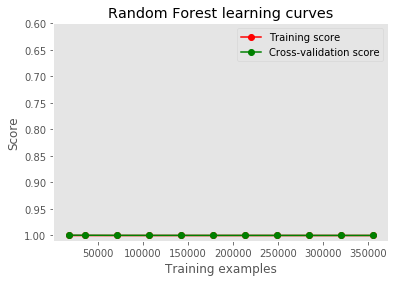

In [81]:
g = plot_learning_curve(grid_rf.best_estimator_,
                        "Random Forest learning curves", df_train, df_train_resp, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

We can see from this graph that we neither underfit nor overfit. The model is a good predictor of the data.

## Test Set Evaluation of the Model on Test/Train Split

In [82]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

In [83]:
def classification_eval(estimator,df_test,df_test_resp):
    y_pred =estimator.predict(df_test)
    dec = np.int64(np.ceil(np.log10(len(df_test_resp))))
    
    print("Confusion Matrix")
    print(confusion_matrix(df_test_resp,y_pred),'\n')
    
    print('Classification report')
    print(classification_report(df_test_resp, y_pred, digits=dec))
    
    print("Scalar Metrics")
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(df_test_resp, y_pred)))
    
    if df_test_resp.nunique() <= 2: # Additional metrics for binary classification
        try:
            y_score = estimator.predict_proba(df_test)[:,1]
        except:
            y_score = estimator.decision_function(df_test)
        print(format_str % ('AUPRC', average_precision_score(df_test_resp, y_score)))
        print(format_str % ('AUROC', roc_auc_score(df_test_resp, y_score)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(df_test_resp, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(df_test_resp, y_pred)))

In [84]:
def rocgraph(y_pred,df_test,df_test_resp):
    y_pred = grid_rf.predict(df_test) # needs changing
    fpr, tpr, threshold = metrics.roc_curve(df_test_resp, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    # plot RoC curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



In [85]:
classification_eval(grid_rf, df_test, df_test_resp)

Confusion Matrix
[[ 9731     0]
 [    3 39673]] 

Classification report
              precision    recall  f1-score   support

           0    0.99969   1.00000   0.99985      9731
           1    1.00000   0.99992   0.99996     39676

    accuracy                        0.99994     49407
   macro avg    0.99985   0.99996   0.99990     49407
weighted avg    0.99994   0.99994   0.99994     49407

Scalar Metrics
          MCC = 0.99981
        AUPRC = 1.00000
        AUROC = 1.00000
Cohen's kappa = 0.99981
     Accuracy = 0.99994


According to the MCC, the random forest performed better on the test set than on the training set. This is probably due to the refit model being trained on the entire training data set, and not on the smaller CV folds.

We can also see from the Confusion matrix that there were 3 events that were false negatives and were therefore predicted to be normal but were actually non-normal events. After performing some analysis, two of these were smurf attacks and one of them was a neptune attack. 

The two smurf attacks, event 6054 and 13077 had exactly the same factors as each other. When analysing the two attacks that weren't predited by the model, we find that both of them have the same values as the median of all the other smurf attacks and thus I'm not sure why they weren't identified when others were. On the other hand, this is a $$ 2/28200 = 0.00007 $$ failure rate and thus is negligible.

The neptune attack was event 47418. Similarly to the smurf attacks, the factors of this model had values that were within the median-75% quartile of this attack and thus I'm not sure why it wasn't identified when other were. On the other hand, this is a $$ 1/10603 = 0.00009 $$ failure rate and thus is negligible.

## Supplied Test Set Evaluation of the model

In [86]:
classification_eval(grid_rf_stest, df_stest, df_stest_resp)

Confusion Matrix
[[ 60295    297]
 [ 22343 228093]] 

Classification report
              precision    recall  f1-score   support

           0   0.729628  0.995098  0.841933     60592
           1   0.998700  0.910784  0.952718    250436

    accuracy                       0.927209    311028
   macro avg   0.864164  0.952941  0.897325    311028
weighted avg   0.946281  0.927209  0.931135    311028

Scalar Metrics
          MCC = 0.812268
        AUPRC = 0.993433
        AUROC = 0.981521
Cohen's kappa = 0.796095
     Accuracy = 0.927209


We have 60925 correct normal predictions and 297 values that were predicted to be attacks but were actually normal. Thus we have an accuracy rate for normal data of $ 99.5\%. $ We have 228093 correct predictions of attacks and 22343 predictions that were predicted as normal but were actually attacks and thus we have an accuracy rate for attack data of $ 91.1\%. $ 

The precision rates above show how well we predict the data which is more important as it accounts for the false positives and false negatives that we have. Our precision rate for normal data (0) is $ 73\% $ which is low and thus we struggle with predicting normal data but our precision rate for attack data (1) is $ 99.9\% $ which shows that the model is very good at predicting new data that it hasnt experienced before.

## Evaluator for Attack Splits

In [87]:
# we have to rewrite the testing in the case where we only have one event (non-normal)
# in the testing data set and therefore an ROC AUC score is undefined
def classification_eval_onetype(estimator,df_test,df_test_resp):
    y_pred =estimator.predict(df_test)
    dec = np.int64(np.ceil(np.log10(len(df_test_resp))))
    
    print("Confusion Matrix")
    print(confusion_matrix(df_test_resp,y_pred),'\n')
    
    print('Classification report')
    print(classification_report(df_test_resp, y_pred, digits=dec))
    
    print("Scalar Metrics")
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(df_test_resp, y_pred)))
    
    if df_test_resp.nunique() <= 2: # Additional metrics for binary classification
        try:
            y_score = estimator.predict_proba(df_test)[:,1]
        except:
            y_score = estimator.decision_function(df_test)
        print(format_str % ('AUPRC', average_precision_score(df_test_resp, y_score)))
        #print(format_str % ('AUROC', roc_auc_score(df_test_resp, y_score)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(df_test_resp, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(df_test_resp, y_pred)))

## Test Set Evaluation of the Model on Teardrop Split

In [88]:
classification_eval_onetype(grid_rf_tear, df_teardrop, df_teardrop_resp)

Confusion Matrix
[[  0   0]
 [788 191]] 

Classification report
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      1.000     0.195     0.326       979

    accuracy                          0.195       979
   macro avg      0.500     0.098     0.163       979
weighted avg      1.000     0.195     0.326       979

Scalar Metrics
          MCC = 0.000
        AUPRC = 1.000
Cohen's kappa = 0.000
     Accuracy = 0.195


/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


From this report, we see that the classifier struggles to predict the teardrop attacks despite having other DDoS attacks within the training data. The model has 788 false negatives and 191 true positives, leaving it with a true positive rate of only 19.5%. Thus we miss over 80% of the attacks and therefore cannot predict them well.

## Test Set Evaluation of the Model on Rootkit Split

In [89]:
classification_eval_onetype(grid_rf_rootkit, df_rootkit, df_rootkit_resp)

Confusion Matrix
[[ 0  0]
 [10  0]] 

Classification report
              precision    recall  f1-score   support

           0        0.0       0.0       0.0       0.0
           1        0.0       0.0       0.0      10.0

    accuracy                            0.0      10.0
   macro avg        0.0       0.0       0.0      10.0
weighted avg        0.0       0.0       0.0      10.0

Scalar Metrics
          MCC = 0.0
        AUPRC = 1.0
Cohen's kappa = 0.0
     Accuracy = 0.0


/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Again similarly, we see that the model struggles to preduct the rootkit events. The model has a 100% failure rate when predicting these events. The small dataset to predict may have an impact on this and may cause the failure in this respect. Furthermore, the other u2r attacks only represent 0.004% of the data set and therefore the opportunitites to find links between similar events are very small.

## Test Set Evaluation of the Model on Guess Password Split

In [90]:
classification_eval_onetype(grid_rf_guessp, df_guessp, df_guessp_resp)

Confusion Matrix
[[ 0  0]
 [53  0]] 

Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00      53.0

    accuracy                           0.00      53.0
   macro avg       0.00      0.00      0.00      53.0
weighted avg       0.00      0.00      0.00      53.0

Scalar Metrics
          MCC = 0.00
        AUPRC = 1.00
Cohen's kappa = 0.00
     Accuracy = 0.00


/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


We have another outcome where the model fails to predict attacks. Similar to the Rootkit split, we have a small amount of r2l data to get mutual information from, compromising only 0.2% of the data. This means that the data set may be difficult to predict.

## Test Set Evaluation of the Model on Portsweep Split

In [91]:
classification_eval_onetype(grid_rf_psweep, df_psweep, df_psweep_resp)

Confusion Matrix
[[  0   0]
 [ 50 990]] 

Classification report
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.9519    0.9754      1040

    accuracy                         0.9519      1040
   macro avg     0.5000    0.4760    0.4877      1040
weighted avg     1.0000    0.9519    0.9754      1040

Scalar Metrics
          MCC = 0.0000
        AUPRC = 1.0000
Cohen's kappa = 0.0000
     Accuracy = 0.9519


/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/User-MC/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Finally, we have an attack type that our model isn't exposed to during the training data but successfully predicts. We have a true positive rate of 0.9519 for the Portsweep Attack which is a very good prediction level. This may be due to the larger amount of data we have in our training set to learn about probe attacks.

## Conclusion

We were able to accurately identify non-normal vs normal traffic using the Random Forest model. We found that he five most correlated variables with normal/non-normal data are, in decreasing order, src_bytes, count, dst_bytes, dst_host_same_src_port_rate & srv_count. We had to perform some data manupulation before running the models which included:
1. Getting rid of unwanted columns.
2. Adding in events to each data set to ensure we covered all factors in both data sets.
3. Ensuring all data was in integer format by using dummie variables.

We used the Matthews correlation coefficient (MCC) to review the performance of the model. In cross validation, the Random Forest achieved a cross-validated MCC score of 0.999 with 3 false-negatives when testing on the test/train split we conducted.

Another interesting fact to address is that when using splits where attacks were removed, we achieved a worse MCC score. This is only by 1% but this may show that the model is better trained when using a variety of data than when excluding specific attacks.

On the other hand, when predicting 'new' attacks that it hasn't experienced before, the model seems to struggle to predict them. This may be due to the large amount of features compared to the amount of data points we have, which is supported by the Portsweep results although combatted by the Teardrop results.

We contradict this statement with the supplied testing data. This data contains attacks that are not within the training data set and thus is a much better example of how well our model predicts out of sample attacks. We find in this case we have an accuracy of $ 92.7\% $ which is high and thus demonstrates that we do predict other attacks well.

## References

1. [Source of data](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)
2. [Source of headers for the data table](http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names)
3. [How to create dummy variables](https://stackoverflow.com/questions/40643831/value-error-could-not-convert-string-to-float-while-using-sklearn-feature-relev)
4. [Information regarding sklearn.mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)
5. [Information regarding sklearn.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
6. [Credit Card Fraud Analysis which introduced me to Random Forest](https://www.kaggle.com/guptanandita/kernel7a055de514)
7. [Information regarding sklearn.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
8. [Plotting an ROC curve](https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python)
9. [Example of learning curves](https://www.kaggle.com/fabiendaniel/customer-segmentation)